In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pickle
from sklearn.neighbors import NearestNeighbors
from utils import * 

In [4]:
file_path = "data/trajectory.csv"
df = pd.read_csv(file_path, index_col=0)

with open('data/shared_variables.pkl', 'rb') as file_object:
    vars = pickle.load(file_object)

#Look in Datatransformation for order of variables
lower_spread_limit, upper_spread_limit, num_values = vars[0], vars[1], vars[2]

In [5]:
#We assume there is a upper and lower limit of pricespread. Dealers only use three decimals so I multiply by 1000. 
num_actions = int((upper_spread_limit-lower_spread_limit)*1000)
num_states = np.prod(num_values)

In [4]:
#Alpha functions: Have to satisfy Robbins-Monro conditions
def alpha_1(N_t): #nt number of times action a is taken in given state 
    return 2/((N_t**(2/3))+1)

def alpha_2(t): #simplest alpha function 
    return 1/(t+1)


In [5]:
def TD(D, gamma, num_states):
    '''
    Implementation of Temporal Difference policy evaluation.

    :param D: Trajectory we want to learn from. 
    :param gamma: Discount factor when using discounted MDPs.
    :param numstates: Number of states in MDP. 
    '''

    #Make Value vectyor
    V = np.zeros(num_states)

    for t in range(len(D)-1):
        s, r, ns = int(D.iloc[t]['State_index']), D.iloc[t]['Reward'], int(D.iloc[t]['Next_State']) 
        alpha = alpha_2(t+1)
        V[s] += alpha*(r+gamma*V[ns]-V[s]) 

    return V


def TD_lambda(D, gamma, num_states, lambd):
    '''
    Implementation of Temporal Difference policy evaluation looking l steps into the future.

    :param D: Trajectory we want to learn from. 
    :param gamma: Discount factor when using discounted MDPs.
    :param numstates: Number of states in MDP.
    :param lambd: lambda value to weight the future insight. 
    '''
    
    #Make Value vectyor
    V = np.zeros(num_states)
    
    T = len(D)-1
    for t in range(T):
        s_t = int(D.iloc[t]['State_index']) 
        alpha = alpha_2(t+1)
        sum = 0 
        for n in range(T-t):
            s, r, ns = int(D.iloc[t+n]['State_index']), D.iloc[t+n]['Reward'], int(D.iloc[t+n]['Next_State']) 
            sum += (lambd**n) * (gamma**n) * (r+gamma*V[ns]-V[s])
        V[s_t] += alpha*sum 

    return V


In [6]:
gamma = 0.95

V_b = TD(df, gamma, num_states)
np.max(V_b)

 

0.012937416772247703

In [7]:
V_b_lambda = TD_lambda(df, gamma, num_states, 0.5)
np.max(V_b_lambda)

0.013141673553177143

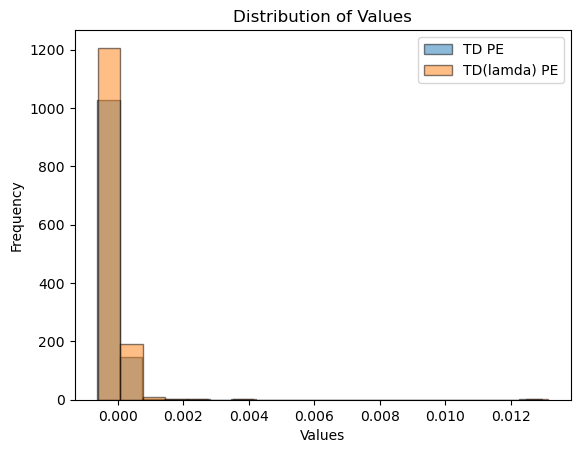

In [8]:
df_values = pd.DataFrame(V_b, columns=['Values'])
non_zero_rows = df_values[~(df_values["Values"] == 0.00)]

df_values_lambda = pd.DataFrame(V_b_lambda, columns=['Values'])
non_zero_rows_lambda = df_values_lambda[~(df_values_lambda["Values"] == 0.00)]


plt.hist(non_zero_rows, bins=20, edgecolor='black', label="TD PE", alpha=0.5)
plt.hist(non_zero_rows_lambda, bins=20, edgecolor='black', label="TD(lamda) PE", alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.legend()
plt.show()

In [6]:
def estimate_behavior_policy_distribution(dataset, k, num_states, num_actions, num_values, smoothing_factor=1.0):
    """
    Estimates the behavior policy distribution using kNN with Laplace smoothing.

    Args:
        dataset (pd.DataFrame): A DataFrame with the first column as a list of feature values.
        k (int): Number of nearest neighbors to consider.
        smoothing_factor (float): Smoothing factor for Laplace smoothing (default is 1.0).
        num_states: Number of states in MDP
        num_actions: Number of actions in MDP

    Returns:
        np.ndarray: A 2D array of shape (num_states, num_actions) representing the estimated probability distribution pi(a|*) of the behavior policy.
    """
    # Initialize an array to store action counts for each state
    probability_table = np.zeros((num_states, num_actions), dtype=np.float32)
    print("proptable shape", probability_table.shape)

    # Convert the first column (list of feature values) from string to a list
    #features = np.array(dataset.iloc[:, 0].apply(eval).tolist())  # Convert string representation to list
    features = np.array([index_to_state(x, num_values) for x in df.iloc[:, 0]])

    print("features shape", features.shape)

    # Fit kNN model to the features
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(features)

    # For each state, find k nearest neighbors
    for i in range(num_states):
        if i % 10000 == 0:
            print("10k iterations done")
        state_vector = index_to_state(i, num_values)
        _, indices = knn.kneighbors([state_vector])  # Indices of nearest neighbors
        for j in indices[0]:
            action = int(dataset.iloc[j, -1])  # Assuming action is stored in the last column
            probability_table[i, action] += 1

    # Apply Laplace smoothing
    behavior_policy = (probability_table + smoothing_factor) / (k + smoothing_factor * num_actions)

    # Normalize rows to ensure they sum up to 1
    behavior_policy /= np.sum(behavior_policy, axis=1, keepdims=True)

    return behavior_policy


In [7]:

estimated_policy_with_smoothing = estimate_behavior_policy_distribution(df[["State_index", "Action"]], k=4, 
                                                                        num_states=num_states, num_actions=num_actions, num_values=num_values, smoothing_factor=1.0)

proptable shape (36864, 180)
features shape (4711, 8)
10k iterations done
10k iterations done
10k iterations done
10k iterations done


In [11]:
print("sum of proabilities row 1", np.sum(estimated_policy_with_smoothing[3000]))
print("min prob", np.min(estimated_policy_with_smoothing))
print("max prob", np.max(estimated_policy_with_smoothing))

sum of proabilities row 1 1.0
min prob 0.0054347827
max prob 0.027173916


### Make Importance Weighted Sampling

In [8]:
#This only makes sense if we just have one state we are interested in calculating value for. 

policy_QL = pd.read_csv('policies/QL.csv', index_col=0)
policy_DQL = pd.read_csv('policies/DQL.csv', index_col=0)

print(policy_QL.head(5))

print(df.head(5))

   Policy  Converted_to_Spread
0       0                -0.03
1       0                -0.03
2       0                -0.03
3       0                -0.03
4       0                -0.03
   State_index  Action  Reward  Next_State
0        25416      55   0.026        5944
1         5944      51   0.000        6023
2         6023      82   0.000        8796
3         8796      96   0.000         622
4          622      58   0.000        3725


In [17]:
#Make single V_IS for one trajectory
def rho_t(trajectory, t, behaviour_policy, target_policy):
    #trajectory up to timestep t 
    trajectory = trajectory.iloc[:t+1,:]
    fractions = []
    for t in range(len(trajectory)):
        s, a = int(trajectory.iloc[t]['State_index']), int(trajectory.iloc[t]['Action']) 
        pi_B = behaviour_policy[s,a]
        pi = 1 if target_policy.iloc[s]['Policy'] == a else 0 
        fractions.append(pi/pi_B)
    print(fractions)
    return np.prod(fractions)


def IS(trajectory, gamma, behaviour_policy, target_policy):
    rho = rho_t(trajectory, len(trajectory), behaviour_policy, target_policy)
    sum = 0
    for t in range(len(trajectory)):
        r = trajectory.iloc[t]['Reward']
        sum += (gamma**t)*r
    return rho * sum, rho

def PDIS(trajectory, gamma, behaviour_policy, target_policy):
    sum = 0
    for t in range(len(trajectory)):
        print('t', t)
        rho = rho_t(trajectory, t, behaviour_policy, target_policy)
        r = trajectory.iloc[t]['Reward']
        print('r', r)
        sum += rho*(gamma**t)*r
    return sum


In [14]:
value, rho = IS(df, gamma, estimated_policy_with_smoothing, policy_QL)
print(f"value: {value}, rho: {rho}")

#value_PDIS = PDIS(df, gamma, estimated_policy_with_smoothing, policy_QL)
#print(f"value PDIS: {value_PDIS}")


value: 0.0, rho: 0.0
value PDIS: 0.0


### Test of methods

In [18]:
file_path = "data/trajectory.csv"
df = pd.read_csv(file_path, index_col=0)

trajectory_test = df.head(10)

#This only makes sense if we just have one state we are interested in calculating value for. 

policy_QL = pd.read_csv('policies/QL.csv', index_col=0)
policy_DQL = pd.read_csv('policies/DQL.csv', index_col=0)

gamma=0.95

value, rho = IS(trajectory_test, gamma, estimated_policy_with_smoothing, policy_QL)

value = PDIS(trajectory_test, gamma, estimated_policy_with_smoothing, policy_QL)

print(value)

[91.99999040365319, 0.0, 0.0, 0.0, 0.0, 91.99999040365319, 0.0, 0.0, 0.0, 0.0]
t 0
[91.99999040365319]
r 0.0259999999999962
t 1
[91.99999040365319, 0.0]
r 0.0
t 2
[91.99999040365319, 0.0, 0.0]
r 0.0
t 3
[91.99999040365319, 0.0, 0.0, 0.0]
r 0.0
t 4
[91.99999040365319, 0.0, 0.0, 0.0, 0.0]
r 0.0
t 5
[91.99999040365319, 0.0, 0.0, 0.0, 0.0, 91.99999040365319]
r 0.0150000000000005
t 6
[91.99999040365319, 0.0, 0.0, 0.0, 0.0, 91.99999040365319, 0.0]
r 0.0
t 7
[91.99999040365319, 0.0, 0.0, 0.0, 0.0, 91.99999040365319, 0.0, 0.0]
r 0.0
t 8
[91.99999040365319, 0.0, 0.0, 0.0, 0.0, 91.99999040365319, 0.0, 0.0, 0.0]
r 0.0
t 9
[91.99999040365319, 0.0, 0.0, 0.0, 0.0, 91.99999040365319, 0.0, 0.0, 0.0, 0.0]
r 0.0
2.3919997504946333


In [15]:
trajectory_test

,State_index,Action,Reward,Next_State
0,25416,55,0.026,5944
1,5944,51,0.000,6023
2,6023,82,0.000,8796
3,8796,96,0.000,622
4,622,58,0.000,3725
5,3725,45,0.015,3610
6,3610,46,0.000,17474
8,17474,40,0.000,18561
9,18561,55,0.000,12933
10,12933,40,0.000,3159
